In [1]:
pwd

'/datax2/users/icrar2021/cho134/fdmt-test/SETI tests/Larger Frame Tests'

In [2]:
import setigen as stg
import bifrost as bf
from bifrost.fdmt import Fdmt
import numpy as np
import blimpy as bl
import matplotlib.pyplot as plt
from astropy import units as u
%matplotlib inline

fdmt= Fdmt()

/home/cho134/.local/lib/python3.9/site-packages/cupy/_environment.py:434: UserWarning: 
--------------------------------------------------------------------------------

  CuPy may not function correctly because multiple CuPy packages are installed
  in your environment:

    cupy, cupy-cuda110

  Follow these steps to resolve this issue:

    1. For all packages listed above, run the following command to remove all
       existing CuPy installations:

         $ pip uninstall <package_name>

      If you previously installed CuPy via conda, also run the following:

         $ conda uninstall cupy

    2. Install the appropriate CuPy package.
       Refer to the Installation Guide for detailed instructions.

         https://docs.cupy.dev/en/stable/install.html

--------------------------------------------------------------------------------

  warnings.warn(f'''


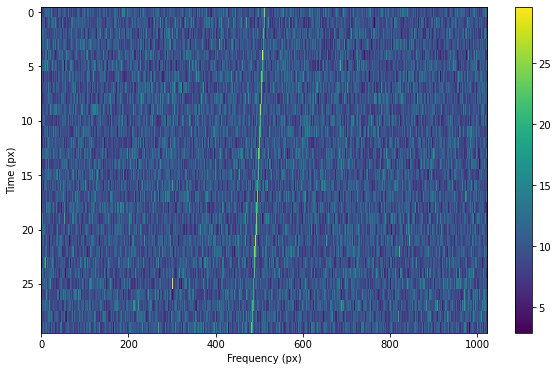

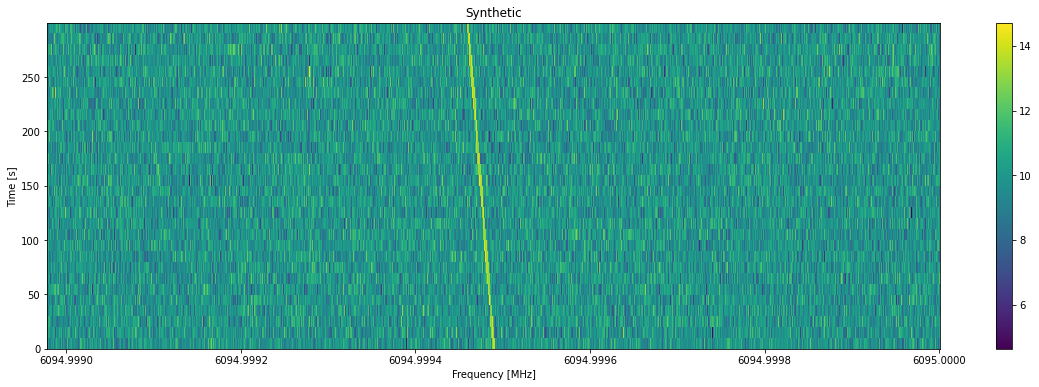

In [134]:
from astropy import units as u
import setigen as stg
import matplotlib.pyplot as plt

frame = stg.Frame(fchans=(1024)*u.pixel,
                  tchans=30*u.pixel,
                  df=1*u.Hz,
                  dt=10*u.s,
                  fch1=6095*u.MHz)
noise = frame.add_noise(x_mean=10, noise_type='chi2')
signal = frame.add_signal(stg.constant_path(f_start=frame.get_frequency(index=frame.fchans/2),
                                            drift_rate=-frame.df/frame.dt),
                          stg.constant_t_profile(level=frame.get_intensity(snr=30)),
                          stg.box_f_profile(width=4*u.Hz),
                          stg.constant_bp_profile(level=1))

# print(frame.get_frequency(1024),frame.get_frequency(0))
# print(frame.ts)
fig = plt.figure(figsize=(10, 6))
frame.plot()
plt.show()

fig = plt.figure(figsize=(20, 6))
frame.bl_plot()
plt.show()

In [152]:
import cupy as cp
import hyperseti

def ddframecenteredtwice(stgframe, gulp_size, exponent):
    
    fr=stgframe
    drift_rate=fr.df/fr.dt
    frequency = fr.dt*fr.tchans*drift_rate
    max_delay=int(frequency*2)
    #print(max_delay)
    #max_delay = max_drift_rate
    gulp_size = gulp_size

    def get_gulp(idx):
        #d_cpu = np.ascontiguousarray(np.expand_dims(fr.data,axis=0))
        d_cpu = np.ascontiguousarray(np.expand_dims(fr.data.squeeze(), axis=0)[..., idx * gulp_size:(idx+1) * gulp_size])

        return d_cpu
    
    d_cpu = get_gulp(0)
    d_cpu = np.expand_dims(fr.data, axis=0) + 0.1
    #print(d_cpu.shape)

    ## Initialize FDMT
    n_disp = max_delay
    n_time = d_cpu.shape[2]
    n_chan = d_cpu.shape[1]
    fdmt.init(n_chan, n_disp, fr.fch1, fr.df, space="cuda", exponent=exponent)


    # Input shape is (1, n_freq, n_time)
    d_in = bf.ndarray(d_cpu, dtype='f32', space='cuda')
    d_out = bf.ndarray(np.zeros(shape=(1, n_disp, n_time)), dtype='f32', space='cuda')

    # Execute FDMT
    fdmt.execute(d_in, d_out, negative_delays=True)
    d_out = d_out.copy(space='system')
    
    d_in = bf.ndarray(d_cpu, dtype='f32', space='cuda')
    d_out2 = bf.ndarray(np.zeros(shape=(1, n_disp, n_time)), dtype='f32', space='cuda')
    
    fdmt.execute(d_in, d_out2, negative_delays=False)
    d_out2 = d_out2.copy(space='system')
    
    fal=np.array(d_out2)
    fal=np.flip(fal, axis=1)
    data=np.concatenate((fal,np.array(d_out)), axis=1)
    
    img = cp.asarray(data.squeeze())
    peaks, xvals, yvals = hyperseti.peak.prominent_peaks(img, num_peaks=1, min_xdistance=100, min_ydistance=100, threshold=100)
    print(peaks)
    xvals = cp.asnumpy(xvals)
    yvals = cp.asnumpy(yvals)
    
    #plotting the fdmt
    plt.figure(figsize=(9, 6))
    plt.imshow(np.log(np.concatenate((fal,np.array(d_out)), axis=1).squeeze()), aspect='auto', extent=[0, fr.fchans, -((max_delay/fr.tchans)*(fr.df/fr.dt)), ((max_delay/fr.tchans)*(fr.df/fr.dt))])
    #plt.imshow(np.log(np.array(data)).squeeze(), aspect='auto')

    #, extent=[0, 1024, 0.23, 0]
    #plt.scatter(xvals, yvals, marker='x', color='#cc0000')
    plt.xlabel("Frequency")
    plt.ylabel("Dispersion trial")
    plt.colorbar()

[705.21045]


/tmp/ipykernel_29219/4025013325.py:57: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.concatenate((fal,np.array(d_out)), axis=1).squeeze()), aspect='auto', extent=[0, fr.fchans, -((max_delay/fr.tchans)*(fr.df/fr.dt)), ((max_delay/fr.tchans)*(fr.df/fr.dt))])


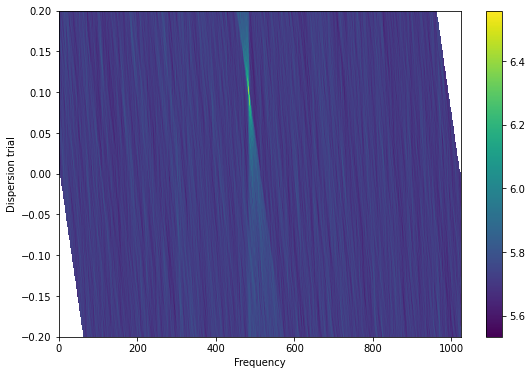

In [153]:
ddframecenteredtwice(frame, 4*8192, 1)

In [6]:
pwd

'/datax2/users/icrar2021/cho134/fdmt-test/SETI tests/Larger Frame Tests'

In [7]:
frame=fr

def turbogulptest(gulp_size,idx):
    np.ascontiguousarray(np.expand_dims(fr.data.squeeze(), axis=0)[..., idx * gulp_size:(idx+1) * gulp_size]).save_h5(filename='TurboFrame.h5')

turbogulptest(4*8192,0)

NameError: name 'fr' is not defined

In [132]:
#TurboSETI Hitserach

import time
from blimpy import Waterfall
from turbo_seti.find_doppler.find_doppler import FindDoppler

H5DIR = "/datax2/users/icrar2021/cho134/fdmt-test/SETI tests/Larger Frame Tests/"
H5PATH = H5DIR + "TurboFrame.h5"
OUT_DIR_BASE = H5DIR

print("\nUsing HDF5 file: {}\nHeader and data shape:".format(H5PATH))
# -- Get a report of header and data shape
wf = Waterfall(H5PATH)
#wf.header['foff'] = 1e-6
wf.info()
# -- Instantiate FindDoppler.
print("\nInstantiating the FindDoppler object.")
fdop = FindDoppler(datafile=H5PATH, max_drift=0.2, snr=30, out_dir=H5DIR,n_coarse_chan=1)
# -- Search for hits and report elapsed time.
print("\nBegin doppler search.  Please wait ...")
t1 = time.time()
fdop.search()
elapsed_time = time.time() - t1
print("\nFindDoppler.search() elapsed time = {} seconds".format(elapsed_time))


Using HDF5 file: /datax2/users/icrar2021/cho134/fdmt-test/SETI tests/Larger Frame Tests/TurboFrame.h5
Header and data shape:

--- File Info ---
DIMENSION_LABELS :   ['time' 'feed_id' 'frequency']
        az_start :                              0.0
       data_type :                                1
            fch1 :                       6095.0 MHz
            foff :                       -1e-06 MHz
           ibeam :                               -1
      machine_id :                               20
          nbeams :                                1
           nbits :                               32
          nchans :                           524288
            nifs :                                1
     rawdatafile :                        Synthetic
     source_name :                        Synthetic
         src_dej :                     -28:22:59.16
         src_raj :                         17:47:15
    telescope_id :                                6
           tsamp :     

In [ ]:
# from timeit import default_timer as timer
# start = timer()
# ddframecenteredtwice(frame,0, 1)
# end = timer()
# print(end - start)

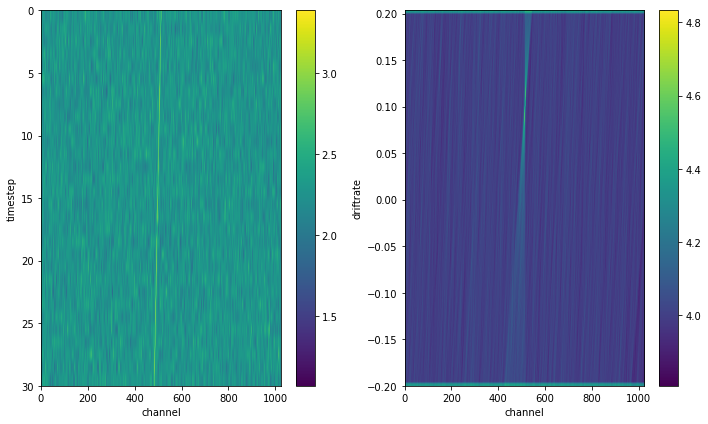

In [137]:
import hyperseti
from hyperseti import dedoppler
from hyperseti import plotting 

fr=frame
drift_rate=fr.df/fr.dt
frequency = fr.dt*fr.tchans*drift_rate
max_delay=int(frequency*2)
    
test_data = np.expand_dims(fr.data.astype('float32'), axis=1)

metadata = {'frequency_start': frame.get_frequency(index=fr.fchans/2)*u.MHz, 'time_step': fr.dt*u.s, 'frequency_step': fr.df*u.Hz}

# Run dedoppler

dedopp, metadata= dedoppler(test_data, metadata, boxcar_size=1, max_dd=(max_delay/fr.tchans)*(fr.df/fr.dt))



# Imshow output
plt.figure(figsize=(10, 6))
plt.subplot(1,2,1)
plotting.imshow_waterfall(np.log(test_data), metadata)
plt.subplot(1,2,2)
plotting.imshow_dedopp(np.log(dedopp), metadata)
plt.tight_layout()


In [ ]:
from hyperseti import hitsearch
metadata = {'frequency_start': frame.get_frequency(index=fr.fchans/2)*u.MHz, 'time_step': fr.dt*u.s, 'frequency_step': fr.df*u.Hz}

hits = hitsearch(dedopp, metadata, threshold=500)

In [ ]:
print(hits)

In [ ]:
plotting.overlay_hits(hits)